Novamente, é quase que o trabalho anterior por inteiro. O que muda é que precisamos implementar um Perceptron Simples.

O Perceptron deve ser testado com diferentes passos de aprendizagem.

Dessa vez, podemos descartar a maioria das figuras de métrica. Deixando apenas a acurácia e a matriz de confusão.

In [1]:
# Bibliotecas
import numpy as np
import pandas as pd

In [2]:
NUM_ROUNDS = 50
PERCEPTRON_LR = 0.01

## Definição dos modelos

A distância euclidiana será utilizada nos dois modelos.

In [3]:
def euclidian_distance(x1, x2):
  return np.sqrt(np.sum((x1 - x2) ** 2))

In [4]:
class KNearestNeighbors:
  def __init__(self, n_neighbors=5):
    self.n_neighbors = n_neighbors

  def fit(self, X, y):
    self.X_train = X
    self.y_train = y

  def predict(self, X_test):
    preds = []

    for x_test in X_test:
      distances = [euclidian_distance(x_test, x_train) for x_train in self.X_train]

      k_nearest_indices = np.argsort(distances)[:self.n_neighbors]
      k_nearest_labels = [self.y_train[i] for i in k_nearest_indices]

      unique_labels, counts = np.unique(k_nearest_labels, return_counts=True)
      most_common_label = unique_labels[np.argmax(counts)]

      preds.append(most_common_label)

    return np.array(preds)

class DMC:
  def __init__(self):
    self.centroids = {}
    self.class_counts = {}

  def fit(self, X, y):
    unique_classes = np.unique(y)

    for cls in unique_classes:
      X_class = X[y == cls]
      self.centroids[cls] = np.median(X_class, axis=0)
      self.class_counts[cls] = len(X_class)

    '''
    print('\nCentróides iniciais calculados:')
    for cls, centroid in self.centroids.items():
      print(f'Classe {cls}: centroid')
    '''

  def predict(self, X_test):
    preds = []

    for i, x_test in enumerate(X_test):
      distances = []
      for cls, centroid in self.centroids.items():
        dist = euclidian_distance(x_test, centroid)
        distances.append((dist, cls))
      distances.sort()
      closest_class = distances[0][1]
      preds.append(closest_class)

      # Atualização do centroide
      current_class = self.class_counts[closest_class]
      new_class = current_class + 1
      alpha = 1 / new_class
      self.centroids[closest_class] = (1 - alpha) * self.centroids[closest_class]
      self.class_counts[closest_class] = new_class

      # print(f'Teste {i+1} ({x_test}) foi classificado como {closest_class}')

    return np.array(preds)

In [5]:
class Perceptron:
  def __init__(self, input_dim, output_dim, lr):
    self.weights = np.random.uniform(-1, 1, (output_dim, input_dim)).astype(np.float32)
    self.bias = np.random.uniform(-1, 1, output_dim).astype(np.float32)
    self.lr = lr

  def fit(self, X, y, epochs=50):
    X = X.astype(np.float32)
    unique_labels, y_mapped = np.unique(y, return_inverse=True)

    for _ in range(epochs):
      outputs = X @ self.weights.T + self.bias
      preds = np.argmax(outputs, axis=1)

      misclassified = preds != y_mapped
      for i in np.where(misclassified)[0]:
        x_i = X[i]
        y_true = y_mapped[i]
        y_pred = preds[i]

        self.weights[y_true] += self.lr * x_i
        self.bias[y_true] += self.lr
        self.weights[y_pred] -= self.lr * x_i
        self.bias[y_pred] -= self.lr

  def predict(self, X):
    X = X.astype(np.float32)
    scores = X @ self.weights.T + self.bias
    return np.argmax(scores, axis=1)

# Datasets

Instalando a biblioteca do UCI Datasets para baixar os datasets.

In [6]:
!pip install ucimlrepo --quiet

In [7]:
from ucimlrepo import fetch_ucirepo

In [8]:
def train_test_split(X, y, test_size=0.2, random_state=None):
  if random_state is not None:
      np.random.seed(random_state)

  n_samples = len(X)
  shuffled_indices = np.random.permutation(n_samples)
  n_test_samples = int(n_samples * test_size)
  test_indices = shuffled_indices[:n_test_samples]
  train_indices = shuffled_indices[n_test_samples:]

  X_train, X_test = X[train_indices], X[test_indices]
  y_train, y_test = y[train_indices], y[test_indices]

  return X_train, X_test, y_train, y_test

In [9]:
def label_encoder(y):
  unique_labels = np.unique(y)
  label_to_int = {label: i for i, label in enumerate(unique_labels)}
  encoded = np.array([label_to_int[label] for label in y])
  return encoded, unique_labels

# Métricas

In [10]:
def accuracy(y_true, y_pred):
  return np.sum(y_true == y_pred) / len(y_true)

In [11]:
def confusion_matrix(y_true, y_pred, all_classes):
  num_classes = len(all_classes)
  class_to_idx = {cls: i for i, cls in enumerate(all_classes)}

  y_true_mapped = y_true.astype(type(all_classes[0]))
  y_pred_mapped = y_pred.astype(type(all_classes[0]))

  conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

  for true_label, pred_label in zip(y_true_mapped, y_pred_mapped):
      if true_label in class_to_idx and pred_label in class_to_idx:
          true_idx = class_to_idx[true_label]
          pred_idx = class_to_idx[pred_label]
          conf_matrix[true_idx, pred_idx] += 1

  return conf_matrix

# Função genérica

O código é muito repetitivo, mas como nossos modelos foram implementados de forma parecida, conseguimos criar uma função genérica para lidar com todos os casos.

In [12]:
def evaluate_and_get_metrics(X, y):
  print("Dimension of input data:", X.shape)

  y_encoded, class_labels = label_encoder(y)
  num_classes = len(class_labels)

  metrics_results = {
    "knn3": {"acc": [], "conf_matrix": np.zeros((num_classes, num_classes))},
    "knn5": {"acc": [], "conf_matrix": np.zeros((num_classes, num_classes))},
    "dmc":  {"acc": [], "conf_matrix": np.zeros((num_classes, num_classes))},
    "Perceptron": {"acc": [], "conf_matrix": np.zeros((num_classes, num_classes))},
  }
  models = {
      "knn3": KNearestNeighbors(n_neighbors=3),
      "knn5": KNearestNeighbors(n_neighbors=5),
      "dmc": DMC(),
      "Perceptron": Perceptron(X.shape[1], num_classes, PERCEPTRON_LR)
  }

  for i in range(NUM_ROUNDS):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.2, random_state=i)
    for label, model in models.items():
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)

      acc = accuracy(y_test, y_pred)
      cm = confusion_matrix(y_test, y_pred, np.arange(num_classes))

      metrics_results[label]["acc"].append(acc)
      metrics_results[label]["conf_matrix"] += cm

  summary_table = {}
  conf_matrices = {}
  model_names = {'knn3': 'KNN (k=3)', 'knn5': 'KNN (k=5)', 'dmc': 'DMC',
                 'Perceptron': 'Perceptron'}

  for model_label, values in metrics_results.items():
    name = model_names[model_label]
    summary_table[name] = {
      'Accuracy': f'{np.mean(values["acc"]):.4f} ± {np.std(values["acc"]):.4f}',
    }
    conf_matrices[name] = values['conf_matrix'] // 10

  return pd.DataFrame.from_dict(summary_table, orient='index'), conf_matrices

# Teste com o Iris

Download do dataset

In [13]:
iris = fetch_ucirepo(id=53)

X = iris.data.features
y = iris.data.targets.values.ravel()

iris_class_labels = np.unique(y)
iris_class_names = [name.replace('Iris-', '') for name in iris_class_labels]

num_classes = len(iris_class_labels)

## Antes da seleção de atributos

In [14]:
iris_metrics_og, iris_conf_matrices_og = evaluate_and_get_metrics(X.values, y)

Dimension of input data: (150, 4)


## Seleção de atributos

Atributo-atributo

In [15]:
X.corr()

,sepal length,sepal width,petal length,petal width
sepal length,1.000000,-0.109369,0.871754,0.817954
sepal width,-0.109369,1.000000,-0.420516,-0.356544
petal length,0.871754,-0.420516,1.000000,0.962757
petal width,0.817954,-0.356544,0.962757,1.000000


Atributo-saída

In [16]:
y_encod, _ = label_encoder(iris.data.targets['class'])

X.corrwith(pd.Series(y_encod, name='Target'))

,0
sepal length,0.782561
sepal width,-0.419446
petal length,0.949043
petal width,0.956464


Remoção de atributos

In [17]:
REMOVE_COLUMNS = ['sepal width', 'petal width']

X_reduced = X.drop(columns=REMOVE_COLUMNS)

## Depois da seleção de atributos

In [18]:
iris_metrics_alt, iris_conf_matrices_alt = evaluate_and_get_metrics(X_reduced.values, y)

Dimension of input data: (150, 2)


# Teste com Dermatology

In [19]:
dermatology = fetch_ucirepo(id=33)

X = dermatology.data.features
y = dermatology.data.targets.values.ravel()

dermatology_class_labels = np.unique(y)
dermatology_class_names = [
    'psoriasis', 'seboreic dermatitis', 'lichen planus',
    'pityriasis rosea', 'cronic dermatitis', 'pityriasis rubra pilaris'
]

Normalização do dataset e tratamento de NaN

In [20]:
X.loc[:, 'age'] = X['age'].fillna(X['age'].mean())

## Antes da seleção de atributos

In [22]:
dermatology_metrics_og, dermatology_conf_matrices_og = evaluate_and_get_metrics(X.values, y)

Dimension of input data: (366, 34)


## Seleção de atributos

In [23]:
X.corr()

,erythema,scaling,definite-borders,itching,koebner phenomenon,polygonal papules,follicular papules,oral-mucosal involvement,knee elbow involvement,scalp involvement,...,focal hypergranulosis,disappearance of the granular layer,vacuolisation and damage of the basal layer,spongiosis,saw-tooth appearance of retes,follicular horn plug,perifollicular parakeratosis,inflammatory monoluclear infiltrate,band-like infiltrate,age
erythema,1.000000,0.435467,0.260087,-0.047623,0.000694,0.033571,-0.109550,-0.026810,0.141008,0.186684,...,-0.013761,0.159100,0.002559,0.022468,-0.005779,-0.005450,0.009539,0.075758,-0.006955,-0.004974
scaling,0.435467,1.000000,0.357987,-0.084197,-0.010576,-0.075035,-0.092400,-0.082969,0.298398,0.301577,...,-0.085021,0.211484,-0.109523,0.012151,-0.114467,-0.010518,-0.011135,-0.010977,-0.132079,0.015830
definite-borders,0.260087,0.357987,1.000000,-0.062564,0.241342,0.327754,-0.166662,0.286684,0.302309,0.268862,...,0.291147,0.354768,0.298095,-0.255536,0.274576,-0.086250,-0.123947,0.111882,0.282578,0.135968
itching,-0.047623,-0.084197,-0.062564,1.000000,0.267878,0.409696,-0.144825,0.359163,-0.299645,-0.155639,...,0.363488,-0.192684,0.367650,0.017514,0.376186,-0.175866,-0.184074,0.062781,0.386691,0.047388
koebner phenomenon,0.000694,-0.010576,0.241342,0.267878,1.000000,0.394108,-0.172741,0.392554,-0.066372,0.015202,...,0.400409,0.004327,0.376473,-0.005938,0.381687,-0.147955,-0.164364,0.083358,0.382844,0.080329
polygonal papules,0.033571,-0.075035,0.327754,0.409696,0.394108,1.000000,-0.137093,0.865142,-0.276058,-0.253234,...,0.880972,-0.119698,0.911626,0.080063,0.895107,-0.095477,-0.110204,0.228426,0.905822,0.095799
follicular papules,-0.109550,-0.092400,-0.166662,-0.144825,-0.172741,-0.137093,1.000000,-0.132394,0.222255,-0.003535,...,-0.118710,-0.157296,-0.139960,-0.013454,-0.139141,0.785282,0.844929,-0.084864,-0.133871,-0.371012
oral-mucosal involvement,-0.026810,-0.082969,0.286684,0.359163,0.392554,0.865142,-0.132394,1.000000,-0.283466,-0.259813,...,0.884351,-0.106704,0.887552,0.120344,0.875209,-0.082601,-0.106426,0.250937,0.892341,0.110250
knee elbow involvement,0.141008,0.298398,0.302309,-0.299645,-0.066372,-0.276058,0.222255,-0.283466,1.000000,0.659206,...,-0.267508,0.481743,-0.282151,-0.413200,-0.280395,0.232903,0.257661,-0.068621,-0.276711,-0.077980
scalp involvement,0.186684,0.301577,0.268862,-0.155639,0.015202,-0.253234,-0.003535,-0.259813,0.659206,1.000000,...,-0.255554,0.488804,-0.252483,-0.420718,-0.257210,-0.051894,-0.017352,0.035152,-0.249975,0.036277


In [24]:
X.corrwith(dermatology.data.targets['class'])

,0
erythema,-0.335537
scaling,-0.468688
definite-borders,-0.391974
itching,0.054772
koebner phenomenon,-0.091323
polygonal papules,0.057785
follicular papules,0.477813
oral-mucosal involvement,0.055805
knee elbow involvement,-0.383305
scalp involvement,-0.533208


In [25]:
REMOVE_COLUMNS = ['age', 'band-like infiltrate', 'focal hypergranulosis',
                  'hyperkeratosis', 'eosinophils in the infiltrate',
                  'koebner phenomenon']

X_reduced = X.drop(columns=REMOVE_COLUMNS)

## Depois da seleção de atributos

In [26]:
dermatology_metrics_alt, dermatology_conf_matrices_alt = evaluate_and_get_metrics(X_reduced.values, y)

Dimension of input data: (366, 28)


# Teste com Wine

In [27]:
wine = fetch_ucirepo(id=109)

X = wine.data.features
y = wine.data.targets.values.ravel()

wine_class_labels = np.unique(y)
wine_class_names = ['1', '2', '3']
num_classes = len(wine_class_labels)

As targets são valores que representam de onde o vinho vem. Não existem nomes para essas regiões. Elas só são referidas como 1, 2 e 3.

In [28]:
X = 2 * ((X - X.min()) / (X.max() - X.min())) - 1

Desta vez, normalizamos os dados. O Perceptron apresenta resultados muito ruins nesse dataset se não normalizamos.

## Antes da seleção de atributos

In [29]:
wine_metrics_og, wine_conf_matrices_og = evaluate_and_get_metrics(X.values, y)

Dimension of input data: (178, 13)


## Seleção de atributos

Atributo-atributo

In [30]:
X.corr()

,Alcohol,Malicacid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,0D280_0D315_of_diluted_wines,Proline
Alcohol,1.000000,0.094397,0.211545,-0.310235,0.270798,0.289101,0.236815,-0.155929,0.136698,0.546364,-0.071747,0.072343,0.643720
Malicacid,0.094397,1.000000,0.164045,0.288500,-0.054575,-0.335167,-0.411007,0.292977,-0.220746,0.248985,-0.561296,-0.368710,-0.192011
Ash,0.211545,0.164045,1.000000,0.443367,0.286587,0.128980,0.115077,0.186230,0.009652,0.258887,-0.074667,0.003911,0.223626
Alcalinity_of_ash,-0.310235,0.288500,0.443367,1.000000,-0.083333,-0.321113,-0.351370,0.361922,-0.197327,0.018732,-0.273955,-0.276769,-0.440597
Magnesium,0.270798,-0.054575,0.286587,-0.083333,1.000000,0.214401,0.195784,-0.256294,0.236441,0.199950,0.055398,0.066004,0.393351
Total_phenols,0.289101,-0.335167,0.128980,-0.321113,0.214401,1.000000,0.864564,-0.449935,0.612413,-0.055136,0.433681,0.699949,0.498115
Flavanoids,0.236815,-0.411007,0.115077,-0.351370,0.195784,0.864564,1.000000,-0.537900,0.652692,-0.172379,0.543479,0.787194,0.494193
Nonflavanoid_phenols,-0.155929,0.292977,0.186230,0.361922,-0.256294,-0.449935,-0.537900,1.000000,-0.365845,0.139057,-0.262640,-0.503270,-0.311385
Proanthocyanins,0.136698,-0.220746,0.009652,-0.197327,0.236441,0.612413,0.652692,-0.365845,1.000000,-0.025250,0.295544,0.519067,0.330417
Color_intensity,0.546364,0.248985,0.258887,0.018732,0.199950,-0.055136,-0.172379,0.139057,-0.025250,1.000000,-0.521813,-0.428815,0.316100


Atributo-saída

In [31]:
X.corrwith(wine.data.targets['class'])

,0
Alcohol,-0.328222
Malicacid,0.437776
Ash,-0.049643
Alcalinity_of_ash,0.517859
Magnesium,-0.209179
Total_phenols,-0.719163
Flavanoids,-0.847498
Nonflavanoid_phenols,0.489109
Proanthocyanins,-0.499130
Color_intensity,0.265668


Remoção

In [32]:
REMOVE_COLUMNS = ['Ash', 'Magnesium', 'Color_intensity', 'Alcohol',
                  'Malicacid', 'Nonflavanoid_phenols', 'Proanthocyanins']

X_reduced = X.drop(columns=REMOVE_COLUMNS)

## Depois da seleção de atributos

In [33]:
wine_metrics_alt, wine_conf_matrices_alt = evaluate_and_get_metrics(X_reduced.values, y)

Dimension of input data: (178, 6)


# Resultados

In [34]:
import matplotlib.pyplot as plt
import seaborn as sn

## Tabelas

### Iris

In [35]:
print("Dataset: Iris\n")
print("Antes da remoção de atributos:\n")
display(iris_metrics_og)
print("\nDepois da Remoção de atributos:\n")
display(iris_metrics_alt)

Dataset: Iris

Antes da remoção de atributos:



,Accuracy
KNN (k=3),0.9613 ± 0.0293
KNN (k=5),0.9613 ± 0.0315
DMC,0.8647 ± 0.0651
Perceptron,0.9580 ± 0.0711



Depois da Remoção de atributos:



,Accuracy
KNN (k=3),0.9473 ± 0.0299
KNN (k=5),0.9460 ± 0.0339
DMC,0.8507 ± 0.0690
Perceptron,0.9080 ± 0.0793


### Dermatology

In [36]:
print("Dataset: Dermatology\n")
print("Antes da remoção de atributos:\n")
display(dermatology_metrics_og)
print("\nDepois da remoção de atributos:\n")
display(dermatology_metrics_alt)

Dataset: Dermatology

Antes da remoção de atributos:



,Accuracy
KNN (k=3),0.8808 ± 0.0361
KNN (k=5),0.8633 ± 0.0420
DMC,0.5510 ± 0.0520
Perceptron,0.9447 ± 0.0976



Depois da remoção de atributos:



,Accuracy
KNN (k=3),0.9532 ± 0.0207
KNN (k=5),0.9540 ± 0.0224
DMC,0.9293 ± 0.0283
Perceptron,0.9652 ± 0.0220


### Wine

In [37]:
print("Dataset: Wine\n")
print("Antes da remoção de atributos:\n")
display(wine_metrics_og)
print("\nDepois da Remoção de atributos:\n")
display(wine_metrics_alt)

Dataset: Wine

Antes da remoção de atributos:



,Accuracy
KNN (k=3),0.9646 ± 0.0289
KNN (k=5),0.9577 ± 0.0304
DMC,0.9594 ± 0.0303
Perceptron,0.9983 ± 0.0120



Depois da Remoção de atributos:



,Accuracy
KNN (k=3),0.9434 ± 0.0385
KNN (k=5),0.9360 ± 0.0410
DMC,0.9051 ± 0.0519
Perceptron,0.9594 ± 0.0348


## Matrizes de confusão

In [38]:
def plot_confusion_matrices(matrices_before, matrices_after, class_names, dataset_name):
  model_names = list(matrices_before.keys())
  fig, axes = plt.subplots(len(model_names), 2, figsize=(10, 5 * len(model_names)))
  fig.suptitle(f'Matrizes de Confusão Médias - {dataset_name}', fontsize=16, y=1.02)

  for i, model in enumerate(model_names):
    sn.heatmap(matrices_before[model], annot=True, fmt=".0f", cmap='Blues', ax=axes[i, 0],
              xticklabels=class_names, yticklabels=class_names, cbar=False)
    axes[i, 0].set_title(f'{model} (Antes da Remoção)')
    axes[i, 0].set_xlabel('Predito')
    axes[i, 0].set_ylabel('Verdadeiro')
    sn.heatmap(matrices_after[model], annot=True, fmt=".0f", cmap='Greens', ax=axes[i, 1],
                xticklabels=class_names, yticklabels=class_names, cbar=False)
    axes[i, 1].set_title(f'{model} (Depois da Remoção)')
    axes[i, 1].set_xlabel('Predito')
    axes[i, 1].set_ylabel('Verdadeiro')

  plt.tight_layout(rect=[0, 0, 1, 0.98])
  plt.show()


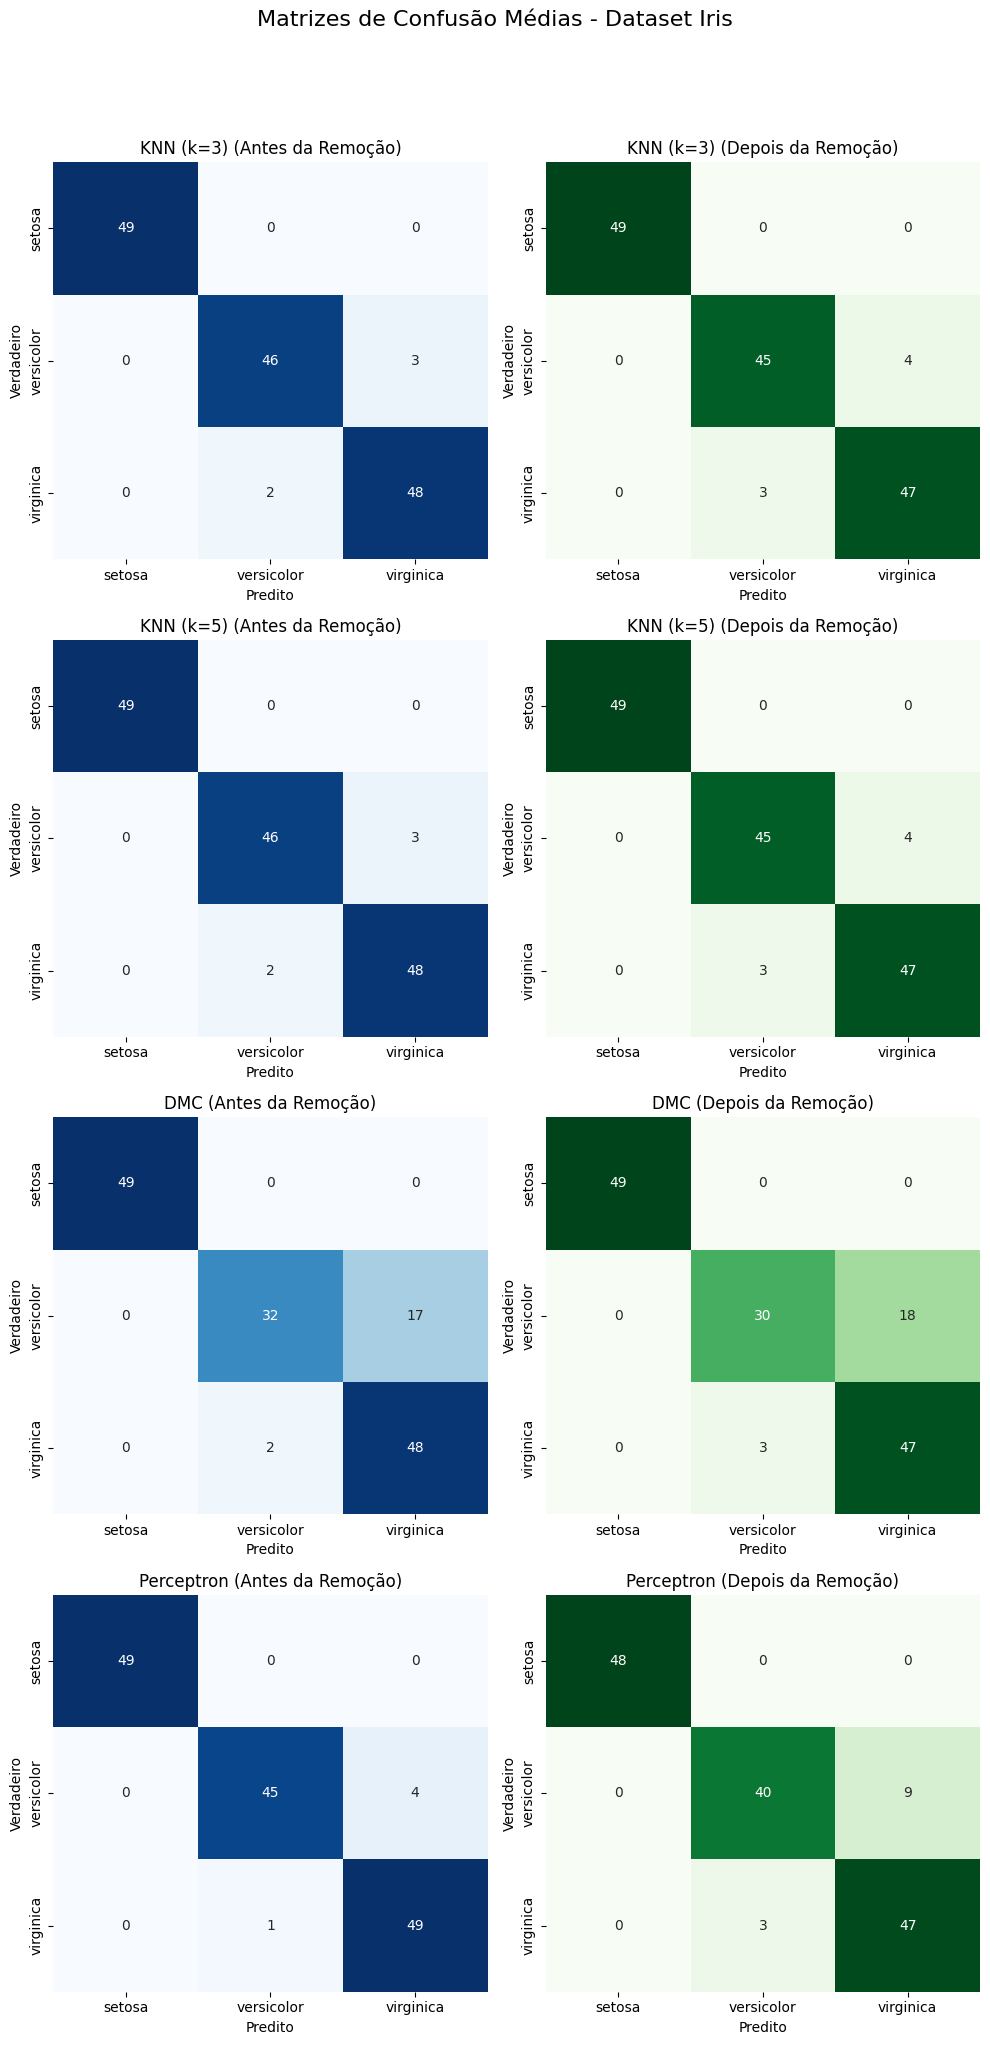

In [39]:
plot_confusion_matrices(iris_conf_matrices_og, iris_conf_matrices_alt, iris_class_names, "Dataset Iris")

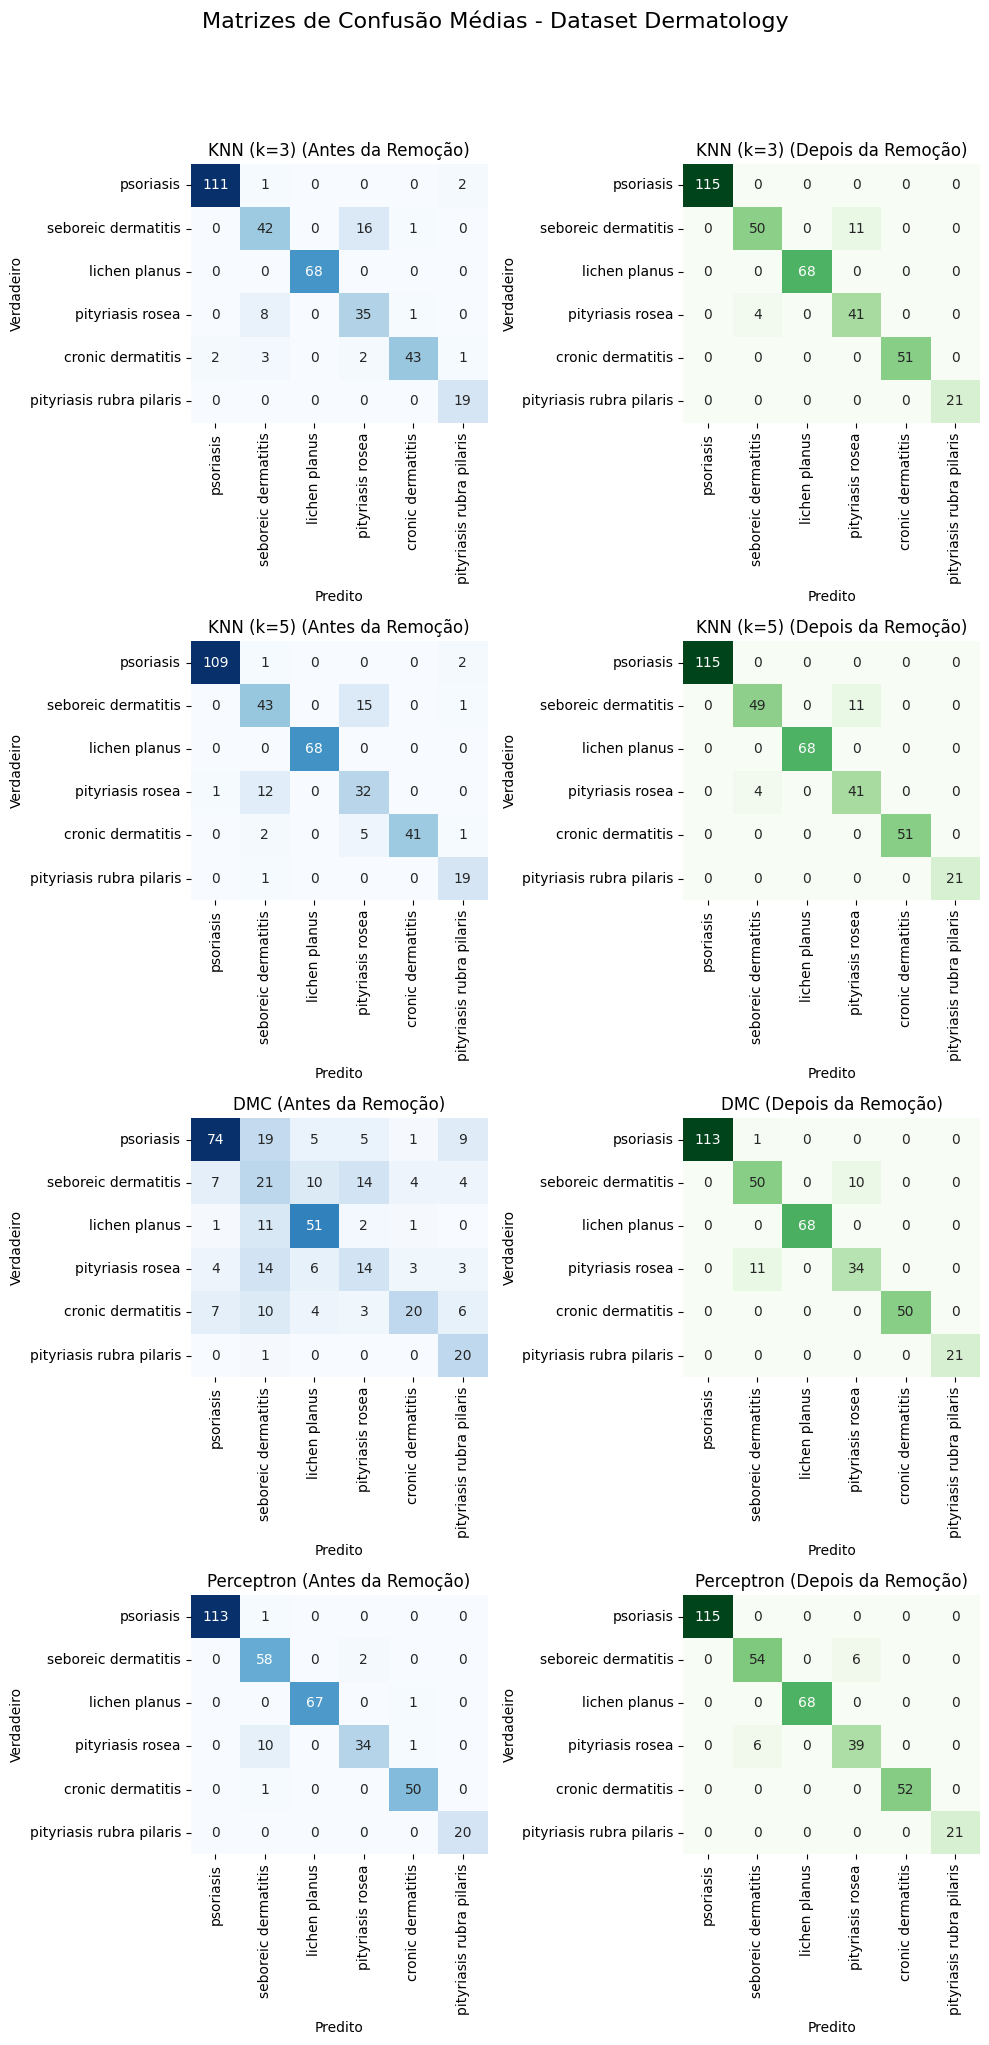

In [40]:
plot_confusion_matrices(dermatology_conf_matrices_og, dermatology_conf_matrices_alt, dermatology_class_names, "Dataset Dermatology")

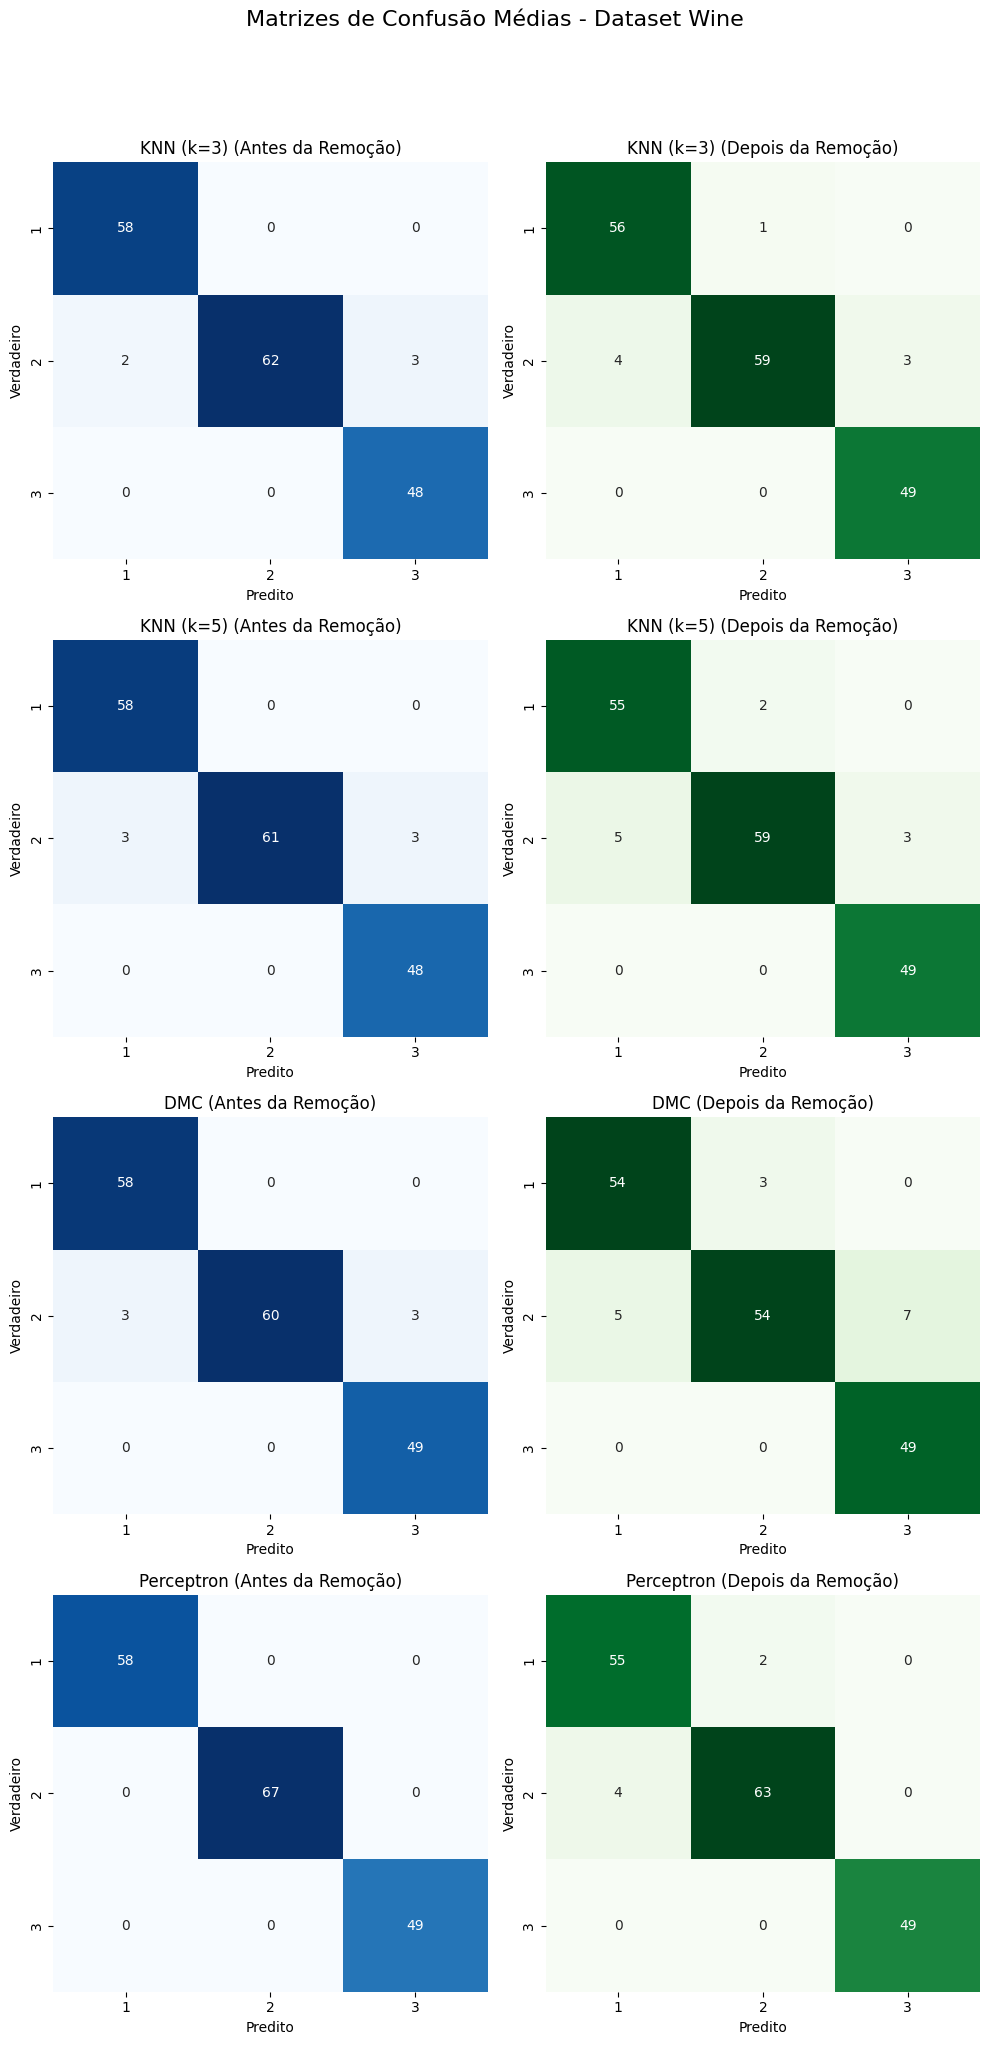

In [41]:
plot_confusion_matrices(wine_conf_matrices_og, wine_conf_matrices_alt, wine_class_names, "Dataset Wine")